In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

from model import KANMixer, PatchEmbedding, Transformation1, Transformation2, MixerLayer

from config import get_config


In [2]:
config = get_config()

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(config["in_channels"])], [0.5 for _ in range(config["in_channels"])]
        ),
    ]
)

In [3]:
# MNIST Dataset
trainset = torchvision.datasets.MNIST(root="./mnist", train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root="./mnist", train=False, download=True, transform=transform)

# # CIFAR10 Dataset
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(trainset, batch_size=config["batch_size"], shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

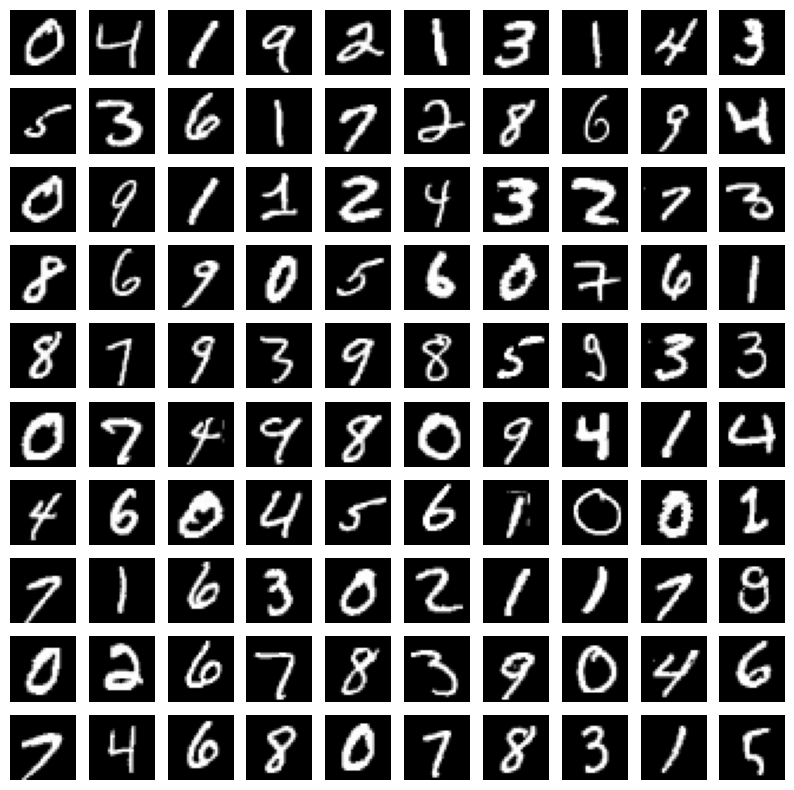

In [4]:
plt.figure(figsize=(10, 10))

for i in range(1, 101, 1):
  plt.subplot(10, 10, i)
  plt.imshow(trainset.data[i], cmap='gray')
  # plt.imshow(trainset.data[i])
  plt.axis('off')
plt.show()

In [2]:
X = torch.rand(64, 1, 28, 28) # MNIST (64, 1, 28, 28), CIFAR10 (64, 3, 32, 32)

pe = PatchEmbedding(1, 128, 4) # MNIST (1, 128, 4), CIFAR10 (3, 128, 4) 
t1 = Transformation1()
t2 = Transformation2()
ml = MixerLayer(128, 49, 256, 256) # MNIST (128, 49, 256, 256), CIFAR10 (128, 64, 256, 256)

print(f"Input shape: {X.shape}")
y1 = pe(X)
print(f"Patch Embedding output shape: {y1.shape}")
y2 = t2(y1)
print(f"T2 transformation output shape: {y2.shape}")
y3 = t1(y2)
print(f"T1 transformation output shape: {y3.shape}")
y4 = t1(y3)
print(f"T1 transformation output shape: {y4.shape}")
y5 = ml(y4)
print(f"Mixer Layer output shape: {y5.shape}")

expanded_grid: torch.Size([6, 49, 12])
input_tensor_expanded: torch.Size([6, 49])
bases: torch.Size([6, 49, 12])
expanded_grid: torch.Size([6, 49, 12])
bases: torch.Size([6, 49, 12])
After computing the B-Spline bases
input_tensor_expanded: torch.Size([6, 49, 10])
expanded_grid (order): torch.Size([6, 49, 10])
left_term: torch.Size([6, 49, 10])


RuntimeError: The size of tensor a (10) must match the size of tensor b (11) at non-singleton dimension 2

In [5]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = KANMixer(in_channels=config["in_channels"], image_size=config["image_size"], patch_size=2, num_classes=10,
                  embedding_dim=config["channel_dim"], depth=config["depth"], token_intermediate_dim=config["token_dim"], channel_intermediate_dim=config["channel_dim"]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])


In [6]:
for epoch in range(config["num_epochs"]):
    model.train()
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    for batch_index, (images, targets) in loop:
        images = images.to(device)
        targets = targets.to(device)
        logits = model(images)
        loss =  criterion(logits, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # progress bar information updating
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")

RuntimeError: The size of tensor a (10) must match the size of tensor b (11) at non-singleton dimension 3

In [ ]:
# Get accuracy on training & test to see how good our model is
def get_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            _, predictions = logits.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples

In [ ]:
print(f"Accuracy on training set: {get_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {get_accuracy(test_loader, model)*100:.2f}")

In [ ]:
def b_splines(self, x: torch.Tensor):
    """
    Compute the B-spline bases for the given input tensor.

    Args:
        x (torch.Tensor): Input tensor of shape (batch_size, in_features).

    Returns:
        torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
    """

    # Expand the grid tensor to match the input tensor's dimensions
    expanded_grid = self.grid.unsqueeze(0).expand(
        x.size(0), *self.grid.size()
    )  # (batch_size, in_features, grid_size + 2 * spline_order + 1)

    # Add an extra dimension to the input tensor for broadcasting
    input_tensor_expanded = x.unsqueeze(-1)  # (batch_size, in_features, 1)

    # Convert tensor into the current device type
    expanded_grid = expanded_grid.to(device)
    input_tensor_expanded = input_tensor_expanded.to(device)

    # Compute the B-spline bases
    bases = torch.zeros_like(expanded_grid)
    for i in range(self.grid_size + 2 * self.spline_order + 1):
        bases[:, :, i] = (input_tensor_expanded >= expanded_grid[:, :, i - 1]) & (input_tensor_expanded < expanded_grid[:, :, i])

    # Compute the B-spline bases recursively
    for order in range(1, self.spline_order + 1):
        left_term = (
            (input_tensor_expanded - expanded_grid[:, :, : -order - 1])
            / (expanded_grid[:, :, order:-1] - expanded_grid[:, :, : -order - 1])
        ) * bases[:, :, :-1]

        right_term = (
            (expanded_grid[:, :, order + 1 :] - input_tensor_expanded)
            / (expanded_grid[:, :, order + 1 :] - expanded_grid[:, :, 1:-order])
        ) * bases[:, :, 1:]

        bases = left_term + right_term

    return bases.contiguous()